In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("notebook")
from scipy.stats import norm

DATA_DIR = 'data'

#### Get the data from csv files that are produced by the python scripts we run on the cluster

In [2]:
# load the mean tone a country has about itself
country_to_country_view = pd.read_csv(os.path.join(DATA_DIR, 'country_to_country_view.csv')).dropna()  # 3 rows have no mention_country
country_inner_view = pd.read_csv(os.path.join(DATA_DIR, 'country_inner_view.csv'))
country_outer_view = pd.read_csv(os.path.join(DATA_DIR, 'country_outer_view.csv'))
country_to_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_to_country_type_view.csv'))
media_to_country_view = pd.read_csv(os.path.join(DATA_DIR, 'media_to_country_view.csv.zip'))

# these files are only used to show some distributions and will not be used 
# for the data analisys later on
afghanistan_inner = pd.read_csv(os.path.join(DATA_DIR, 'afg_inner.csv'))
ivory_coast_outer = pd.read_csv(os.path.join(DATA_DIR, 'ivory_outer.csv'))
mexico_inner = pd.read_csv(os.path.join(DATA_DIR, 'mexico_inner.csv'))

These files contains the same statistical informations for several use cases (what a country thinks of another, difference between types of actors from a country, difference from news sources from a country, ...). The statistical info we chose to extract from the data is always the same, namely:
    - avg_tone: the average tone used by the mentions that corresponds to the row
    - stddev_tone: standard deviation of the average tone
    - count_mentions: number of mentions in the row
    - count_events: number of distinct events in the row (if there are 10 mentions to the same event, count_mentions=10 and count_events=1)
    - avg_conf: average confidence of GDELT into the informations it parsed
    - avg_weighted_tone: average tone weighted by the confidence of GDELT (avg(Tone*Confidence)/avg_conf)
    - std_weighted_tone: std of the weighted tone (std(Tone*Confidence)/avg_conf)
    - first_quartile_tone: first quartile of the tone
    - median_tone: median of the tone
    - third_quartile_tone: third quartile of the tone

In [3]:
# statistical informations about the tone of the news of a country towards another
country_to_country_view.head()

,actor_country,mention_country,avg_tone,stddev_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
0,Afghanistan,Botswana,-1.942005,3.236105,15,15,43.333333,-1.981697,5.082414,-3.574975,-1.971522,-0.603865
1,Albania,Jersey,-5.202312,0.000000,2,2,100.000000,-5.202312,0.000000,-5.202312,-5.202312,-5.202312
2,Albania,Kenya,-2.902415,2.918567,98,54,41.428571,-2.822658,4.137127,-5.345502,-1.954397,-0.400534
3,Antigua and Barbuda,Armenia,-7.448764,3.566137,10,6,49.000000,-7.776772,4.736934,-10.194175,-10.194175,-3.921569
4,Antigua and Barbuda,Russia,-1.930421,3.658752,81,79,45.679012,-2.430936,5.551305,-2.910855,-1.479915,0.000000


In [4]:
# statistical informations about the tone of the news of a country towards itself
country_inner_view.head()

,country,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
0,Yemen,-3.608844,3.585294,10106,8795,44.735801,-3.732185,5.313685,-5.907173,-3.703704,-1.476015
1,Guyana,-2.180227,3.886347,54161,48270,42.249958,-1.987313,4.733579,-4.572565,-1.884701,0.412088
2,Malaysia,-1.757954,3.398342,604138,397239,46.975228,-1.666103,4.283756,-3.859649,-1.646091,0.540541
3,Singapore,-1.133022,3.766699,175191,81500,53.444127,-1.091853,4.470803,-3.529412,-0.784314,1.450677
4,Iraq,-3.648960,3.098804,108114,72500,40.784357,-3.835942,5.053808,-5.543307,-3.500761,-1.586561


In [5]:
# statistical informations about the tone of the news of the external world towards a country
country_outer_view.head()

,country,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
0,Sweden,-3.203392,4.358988,894190,258716,38.043637,-3.020489,5.859831,-6.450158,-3.507653,0.000000
1,Turkey,-4.294582,3.161181,5667893,1513501,37.188643,-4.392249,5.471518,-6.270627,-4.280657,-2.380067
2,Iraq,-3.928116,2.766600,3692731,967934,37.603890,-4.023942,4.794569,-5.518170,-3.817365,-2.182891
3,Sudan,-4.040600,3.478347,552304,208709,36.107289,-4.086113,5.714121,-6.212425,-4.063745,-2.046784
4,Angola,-2.969994,3.881757,116007,49674,38.676632,-2.817222,5.518754,-5.847953,-3.151862,0.000000


In [6]:
# statistical informations about the tone of the news of a country towards the type (government,
# buisnesses,...) of another country
country_to_type_view.head()

,actor_country,mention_country,actor_type,avg_tone,stddev_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
0,Afghanistan,Barbados,GOV,-6.736422,3.256033,16,16,36.875000,-6.656401,6.535354,-9.271523,-9.233792,-4.612546
1,Afghanistan,China,RAD,-2.611754,1.093688,9,5,45.555556,-2.327217,1.537660,-2.247191,-2.247191,-2.247191
2,Afghanistan,Gambia,INS,-4.517831,1.231363,3,3,46.666667,-4.619392,3.767840,-5.228758,-5.228758,-3.095975
3,Afghanistan,North Korea,INS,-5.960580,3.075897,49,49,46.122449,-5.637655,4.869529,-6.572165,-6.571429,-4.852071
4,Afghanistan,Poland,UAF,2.640371,1.299043,7,2,51.428571,2.616605,1.548303,0.985222,3.050847,4.081633


In [7]:
# statistical informations about the tone of the news from a media (website) towards a country
media_to_country_view.head()

,actor_country,source_country,source_name,avg_tone,stddev_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
0,Afghanistan,Australia,governmentnews.com.au,-1.318458,0.000000,1,1,50.000000,-1.318458,0.000000,-1.318458,-1.318458,-1.318458
1,Afghanistan,Austria,ots.at,5.314010,0.000000,6,6,16.666667,5.314010,3.292971,5.314010,5.314010,5.314010
2,Afghanistan,Benin,bittenus.com,1.765772,1.521576,11,10,50.909091,2.035957,1.765785,2.008032,2.012349,2.230971
3,Afghanistan,Canada,dailyheraldtribune.com,-4.650001,3.254665,13,13,54.615385,-4.562309,5.953714,-6.433824,-6.433824,-4.444444
4,Afghanistan,Canada,infotel.ca,-4.742726,3.513820,1963,1900,37.677025,-4.854639,5.871267,-6.726457,-4.341534,-2.343750


#### What statistic to use
We can see from the following plots that the average confidence for the dataframes country_inner_view and country_outer_view vary quite a bit (even tough these are the largest dataset) weighting the tone by the confidence thus makes sense. We should however be cautious with that parameter since it lowers the importance of news that have a low confidence which might lead to bias (ex: most journals in Afghanistan are in afghan except for a few pro-american websites that are in english), due to the language used, the english website news have a much more confidence than the others and thus, Afghanistan seem to dislike the US less than it does in reality). This does not mean that weighting w.r.t. avg_confindence is a bad thing but that it should not be forgotten when analizing results.

The quartiles have the advantage of being robust to outliers but are harder to combine (we cannot get the median tone of the outer_view of Syria from the median tones of the view of every country towards Syria) whereas it's easy for mean and feasible for std.

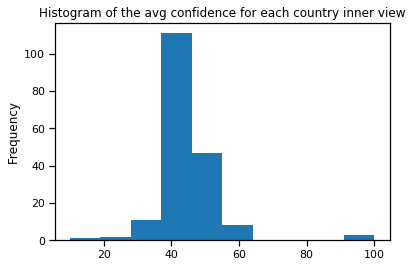

In [8]:
country_inner_view.avg_conf.plot(kind="hist", 
                        title="Histogram of the avg confidence for each country inner view");

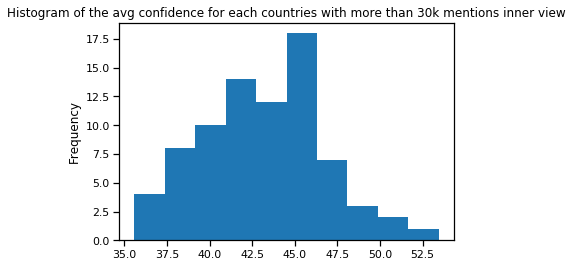

In [9]:
country_inner_view[country_inner_view.count_mentions > 30000].avg_conf.plot(kind="hist",
title="Histogram of the avg confidence for each countries with more than 30k mentions inner view");

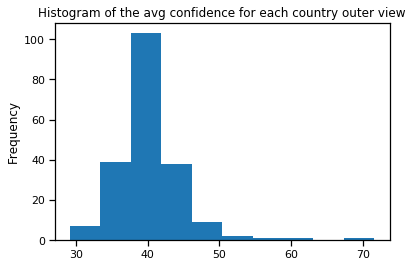

In [10]:
country_outer_view.avg_conf.plot(kind="hist",
                    title="Histogram of the avg confidence for each country outer view");


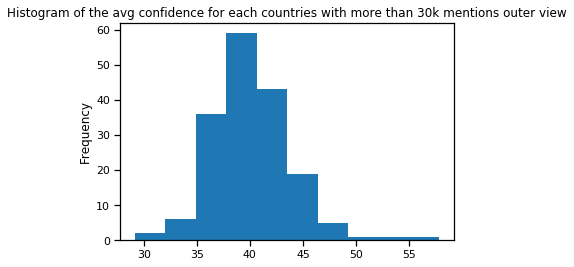

In [11]:
country_outer_view[country_outer_view.count_mentions > 30000].avg_conf.plot(kind="hist",
title="Histogram of the avg confidence for each countries with more than 30k mentions outer view");

#### What about confidence intervals?
A very important thing when dealing with data is to assess its reliability, for example through confidence intervals. Unfortunately, in our case, we do not have the ressources to compute non parametric confidence intervals (for example trough bootstrap resampling). A solution would be to use parametric estimation, assuming the tone is normally distributed. By using the mean, std and quartiles of the tone, we can get a metric expressing how much the data is normally distributed. If we standardize the tone by mean and std, the median tone should be 0 and the 1st and 3rd quartiles -0.6745 and 0.6745, computing the MSE between these data and what they should be give us an estimate on the "normality" of the data. Please note that this metric is very approximate since we only use three points and that there are also errors coming from the computation by spark of the median and quantiles themselves since spark only approximates them. We can however note two things from the following scatterplots:
    - the metric improves with the number of mentions (altough not that much)
    - more importantly, the errors are *huge*, since we are plotting the MSE w.r.t. to values of 0 and +- 0.6745, a MSE of 0.2 is very bad.
Using normal parametrization is thus not reliable either.
To get more insight about the look of the tone distributions, we chose to show up 3 cases, the inner_view of Afghanistan (176586 samples, sqrt(MSE)=0.02), the inner_view of Mexico (29682 samples, sqrt(MSE)=0.065) and the outer_view of the Ivory Coast (105428 samples, sqrt(MSE)=0.17). We can see that Afganistant looks more or less normal, mexico a bit less and ivory coast even less (it even doesn't look symmetric). We can also see that the three of them have a 'gap' at 0 meaning that very small tone values are very unlikely (which makes sense) and that mexico has a several hundreds of tones that are set to exaclty 0.  

However, the mean might be normally distributed even tough the distribution isn't, indeed, the continuous limit theorem states that as n converges towards infinity, the mean of iid samples drawn from any distributions is a $N(\mu, \sigma^2/n)$ variable. We can compare the intervals assuming the CLT holds and the ones obtained by bootstrapping and we can see that these are quite close.  

As a conclusion, provided we have enough samples (which is the case for most of inner and outer view but not for other dataframes). Assuming the mean is normally distributed makes sense altough the tone itself isn't.

In [12]:
def add_sqrt_MSE_with_gaussian_quartiles(df):
    """
    assuming the tone is distributed as a gaussian, the normalized quartiles and 
    median should be approximately equal to the ones of a gaussian distribution 
    (Q1(gaussian) = -0.6745, Q2(gaussian) = 0, Q3(gaussian) = 0.6745).
    
    For rows with a number of mentions of 1, this will return NaN
    """
    q1_squared_error = ((df.first_quartile_tone - df.avg_tone) / df.std_tone + 0.6745)**2
    median_squared_error = ((df.median_tone - df.avg_tone) / df.std_tone)**2
    q3_squared_error = ((df.third_quartile_tone - df.avg_tone) / df.std_tone - 0.6745)**2
    df["sqrt_gaussian_quartile_MSE"] = (q1_squared_error + median_squared_error
                                        + q3_squared_error)**0.5
    return df

In [13]:
def get_mean_bounds_bootstrapping(serie, nbr_boostrap_samples=150, alpha=0.05):
    """
    get confidence intervals obtained by bootstrapping for the mean of the given pandas' serie
    by using nbr_boostrap_samples bootstrap samples and with an alpha given as argument
    
    we reused this code from homework 3
    """
    bound_offset = nbr_boostrap_samples * alpha/2
    min_bound_offset = int(round(bound_offset))
    max_bound_offset = int(round(nbr_boostrap_samples - 1 - bound_offset))

    # Initalising the samples, the means and the bounds arrays
    samples_means = np.zeros(nbr_boostrap_samples)

    # Filling the array
    for i in range(samples_means.shape[0]):
        samples_means[i] = serie.sample(frac=1, replace=True).mean() # we compute the statistic
    # Sorting the samples to allow to get the quantiles
    samples_means.sort()
    return (samples_means[min_bound_offset], samples_means[max_bound_offset])

In [14]:
def get_mean_bounds_normal(serie, alpha=0.05):
    """
    by the Continuous limit theorem, the mean of a R.V. is distributed as N(\mu, \sigma^2/n)
    We will compute the bounds assuming the CLT holds even tough n is finite
    """
    interval = norm.interval(1-alpha)
    sample_mean = serie.mean()
    mean_std = serie.std() / (serie.count()**0.5)
    return (interval[0]*mean_std + sample_mean, interval[1]*mean_std + sample_mean)

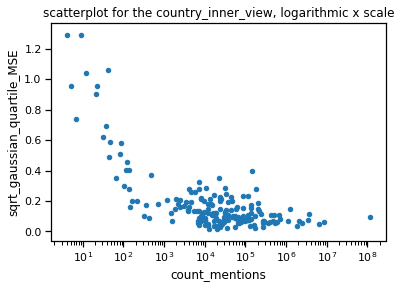

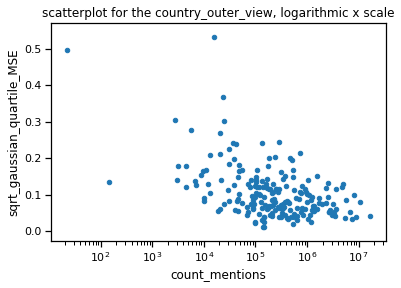

In [15]:
country_inner_view = add_sqrt_MSE_with_gaussian_quartiles(country_inner_view)
country_inner_view.plot(kind='scatter', x="count_mentions", y="sqrt_gaussian_quartile_MSE",
                       title="scatterplot for the country_inner_view, logarithmic x scale",
                       logx=True)

country_outer_view = add_sqrt_MSE_with_gaussian_quartiles(country_outer_view)
country_outer_view.plot(kind='scatter', x="count_mentions", y="sqrt_gaussian_quartile_MSE",
                       title="scatterplot for the country_outer_view, logarithmic x scale",
                       logx=True);

The bounds (95% confidence) obtained by bootstrapping are: (-3.9173028524452422, -3.87512993206991)
Those assuming a normal distribution are: (-3.9188436413882974, -3.8787580581669254)


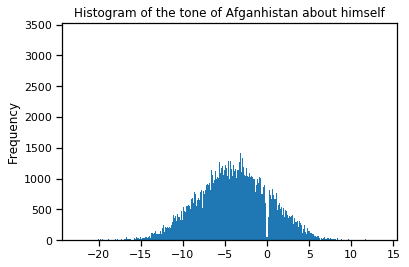

In [16]:
afghanistan_inner.tone.plot(kind='hist', bins=500, 
                            title="Histogram of the tone of Afganhistan about himself");
print(f"The bounds (95% confidence) obtained by bootstrapping are: \
{get_mean_bounds_bootstrapping(afghanistan_inner.tone)}")
print(f"Those assuming a normal distribution are: {get_mean_bounds_normal(afghanistan_inner.tone)}")

The bounds (95% confidence) obtained by bootstrapping are: (-1.8857117831148393, -1.8076125047266058)
Those assuming a normal distribution are: (-1.8845573564774487, -1.8060942590777171)


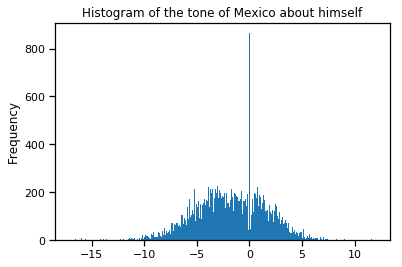

In [17]:
mexico_inner.tone.plot(kind='hist', bins=500, 
                            title="Histogram of the tone of Mexico about himself");
print(f"The bounds (95% confidence) obtained by bootstrapping are: \
{get_mean_bounds_bootstrapping(mexico_inner.tone)}")
print(f"Those assuming a normal distribution are: {get_mean_bounds_normal(mexico_inner.tone)}")

The bounds (95% confidence) obtained by bootstrapping are: (-3.9114699531948425, -3.867592366331419)
Those assuming a normal distribution are: (-3.9124579463617812, -3.862879912430102)


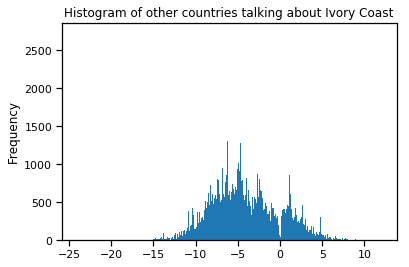

In [18]:
ivory_coast_outer.tone.plot(kind='hist', bins=500, 
                            title="Histogram of other countries talking about Ivory Coast");
print(f"The bounds (95% confidence) obtained by bootstrapping are: \
{get_mean_bounds_bootstrapping(ivory_coast_outer.tone)}")
print(f"Those assuming a normal distribution are: {get_mean_bounds_normal(ivory_coast_outer.tone)}")

#### Rapid data analisys of country_inner_view and country_outer_view
We can see from the following that the average tone is often negative and that it is a bit better for the inner view than the outer view. We can also check that the results makes sense, for example by checking that Pakistan mentions India in a negative way whereas other countries have better relations, like Germany and the US for example.

In [37]:
country_inner_view.describe()

,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone,sqrt_gaussian_quartile_MSE
count,150.000000,150.000000,1.500000e+02,1.500000e+02,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,-1.050314,3.653453,1.071094e+06,3.176271e+05,44.598559,-1.003397,4.646277,-3.265384,-0.806399,1.383104,0.122721
std,1.461484,0.431049,9.656790e+06,2.300080e+06,4.702850,1.461875,0.597618,1.654873,1.579042,1.484258,0.073464
min,-5.103460,2.449634,1.487000e+03,1.421000e+03,33.643279,-5.130436,3.181721,-7.671233,-5.015674,-2.378459,0.015745
25%,-2.041175,3.367694,1.095525e+04,1.000200e+04,41.495568,-1.930872,4.268178,-4.464762,-1.838660,0.483226,0.067848
50%,-1.080954,3.649185,3.277600e+04,2.639850e+04,44.343002,-1.114974,4.536106,-3.375486,-0.784314,1.345444,0.104884
75%,-0.176003,3.927934,1.197735e+05,8.557700e+04,46.579140,-0.142254,5.002352,-2.253055,0.226635,2.390451,0.161068
max,3.204653,5.283884,1.179173e+08,2.801146e+07,58.710699,3.131333,6.526656,1.722282,3.296703,6.060606,0.397855


In [36]:
print(f"number of positive avg_tones for inner_view {np.sum(country_inner_view.avg_tone >= 0)}")

33

In [32]:
country_outer_view.describe()

,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone,sqrt_gaussian_quartile_MSE
count,198.000000,198.000000,1.980000e+02,1.980000e+02,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,-2.608823,3.594188,9.178781e+05,2.848716e+05,40.279363,-2.594871,5.076223,-4.969419,-2.568016,-0.189221,0.102947
std,1.274606,0.410982,1.970463e+06,6.401139e+05,4.403718,1.333432,0.660815,1.406053,1.395686,1.360594,0.066297
min,-5.976917,2.239949,3.015000e+03,1.588000e+03,29.164784,-6.011869,2.531634,-8.366534,-6.122449,-3.878583,0.011764
25%,-3.515726,3.390088,8.702400e+04,3.376250e+04,37.876564,-3.442611,4.669946,-5.931956,-3.461905,-1.101937,0.058079
50%,-2.494903,3.631092,2.202600e+05,7.472400e+04,39.862660,-2.497871,5.059850,-4.979148,-2.483369,0.000000,0.086637
75%,-1.656864,3.856271,7.681650e+05,2.485232e+05,41.782818,-1.624452,5.519759,-4.008733,-1.665486,0.724201,0.127822
max,0.847615,4.759866,1.683009e+07,6.566142e+06,71.612178,1.007224,6.854974,-0.643501,1.511335,3.475936,0.532463


In [35]:
print(f"number of positive avg_tones for outer_view {np.sum(country_outer_view.avg_tone >= 0)}")

5

In [51]:
country_to_country_view[np.logical_and(country_to_country_view["mention_country"] == 'India', 
                       country_to_country_view["actor_country"] == 'Pakistan')]

,actor_country,mention_country,avg_tone,stddev_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
26299,India,Pakistan,-3.71299,3.86601,42647,30495,35.814243,-3.975947,6.311984,-6.21118,-3.404255,-1.091703


#### Example of error to avoid with United Arab Emirates :

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a17af00f0>]],
      dtype=object)

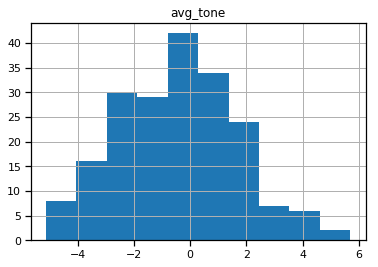

In [24]:
UAE = country_to_country_view[country_to_country_view["mention_country"] == 'United Arab Emirates']
UAE.hist('avg_tone');

We can see that the United Arab Emirates has an avg_tone distributed around zero. We could conclude that others countries have a neutral opinion of this country, but if we keep only the rows with more than one hundred citations:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a833400>]],
      dtype=object)

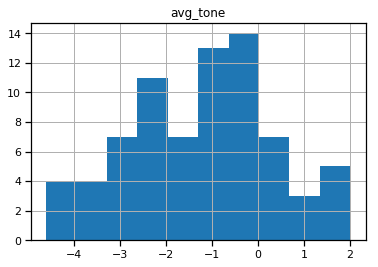

In [25]:
UAE_mentions =  UAE[UAE["count_mentions"] > 1000]
UAE_mentions.hist('avg_tone');

We can see that most of the countries have a negative opinion of the United Arab Emirates. This little example shows that we have to be very careful about our results and take precautions for the explanations.

#### Compares inner and outer view in a scatterplot. 
We could refine the following scatterplot by showing how to divide it into several countries, comment the results, ...

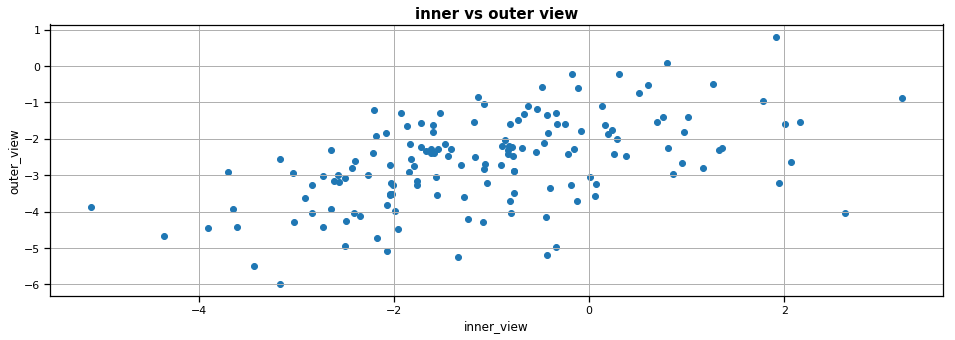

In [26]:
# comparing inner and outer view
country_inner_view = country_inner_view[country_inner_view["count_events"] > 1000]
country_outer_view = country_outer_view[country_outer_view["count_events"] > 1000]
inner_outer_view = country_inner_view.merge(country_outer_view, left_on="country", 
                                            right_on="country", suffixes=("_in", "_out"))
fig, ax = plt.subplots(figsize=(16,5))
ax.scatter(x='avg_tone_in', y='avg_tone_out', data=inner_outer_view)
ax.set_title("inner vs outer view", fontsize=15, fontweight='bold')
ax.set_ylabel('outer_view')
ax.set_xlabel('inner_view')
ax.grid(True)

#### Separation into actor type example with the USA
We use here the USA as an example of what could be done with the country_to_type_view. For simplicity, we did not compute confidence intervals here but this could be done (assuming the repartition of the mean is normal as before). We can see for example that the US police forces (COP) are very unpopular from abroad, the same goes for the judiciary system (JUD) and the media (MED), whereas multi national corporation (MNC) and media are not seen that badly.

In [28]:
country_to_type_USA = country_to_type_view[country_to_type_view.actor_country == "United States"]

# we will get the average tone towards actor types in the US and compare it with the national mean
count_mentions_per_actor_type = country_to_type_USA.groupby("actor_type").count_mentions.sum()
weighted_sum_avg_tone_actor_type = country_to_type_USA.groupby("actor_type").apply(
    lambda x: x.avg_tone * x.count_mentions).groupby("actor_type").sum()
concat = pd.concat([count_mentions_per_actor_type, weighted_sum_avg_tone_actor_type], axis=1)

national_mean = concat.sum()
national_mean = national_mean.loc[0] / national_mean.loc["count_mentions"]
print(f" the average tone nation-wide is {national_mean}")

 the average tone nation-wide is -2.728636659173831


In [29]:
concat = concat[concat.count_mentions > 1000000]
print("when dividing into actor types, we have:")
concat[0] / concat["count_mentions"]

when dividing into actor types, we have:


actor_type
COP   -5.903874
EDU   -1.594095
GOV   -2.184429
JUD   -5.472220
LEG   -1.824396
MED   -3.467980
MNC   -0.633202
dtype: float64

#### Separation into news sources example with the USA and China
We could use the average score from the medias of a country to another to see if medias from a country do not agree on the status of another one. We can see in this very basic example, that the view of big americans new about china varies, for example, we can see that "4-traders.com" usually has a positive tone about China since China is probably very interesting from a trading perspective. This is just a dummy example and there is probably nothing interesting to see here. Another interesting idea would be to compare the average tone of small news websites with the average tone of big news websites about a country.

In [30]:
USA_China = media_to_country_view[np.logical_and(media_to_country_view.source_country == "United States",
                                  media_to_country_view.actor_country == "China")]
USA_China[USA_China.count_mentions > 20000]

,actor_country,source_country,source_name,avg_tone,stddev_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
58952,China,United States,reuters.com,-2.152007,2.750651,138868,49885,41.727828,-2.167459,3.943870,-3.709949,-1.946472,-0.361011
282862,China,United States,yahoo.com,-2.143683,3.115891,182825,112022,41.631123,-2.169520,4.367902,-3.982301,-2.046036,-0.181818
461511,China,United States,bloomberg.com,-1.287174,2.120208,38476,23605,40.744360,-1.366140,2.947172,-2.628918,-1.203209,0.303644
557202,China,United States,blogspot.com,-1.857388,2.553935,22815,21431,37.500329,-1.707879,3.423856,-3.629032,-1.715511,-0.157580
659387,China,United States,nytimes.com,-2.289576,2.670952,22188,20716,39.835947,-2.364019,3.934759,-3.746398,-2.061856,-0.529101
672172,China,United States,businessinsider.com,-1.958092,2.619248,24087,23023,40.274007,-1.983223,3.727654,-3.438395,-1.792115,-0.296296
710515,China,United States,channelnewsasia.com,-2.485944,3.059054,44587,31201,42.125956,-2.575203,4.482945,-4.252199,-2.311248,-0.456621
895423,China,United States,iheart.com,-1.067503,3.691916,29592,896,44.465396,-1.086947,4.304979,-4.026846,-0.934579,1.351351
908162,China,United States,todayonline.com,-2.285084,2.900841,22506,20646,41.764418,-2.342175,4.113598,-3.906250,-2.055921,-0.424628
940014,China,United States,trust.org,-3.178125,2.867782,29598,19075,40.353740,-3.317386,4.637650,-4.809619,-2.873563,-1.190476


#### Goals for next milestone
02/12:
    - use the different types of actors of a country to compute several ranks and compare these between countries with confidence intervals.
    - interpret inner and outer view scatterplot (maybe relate these with PIB, continent, wether the country is seen as a democracy by the occidental world,...)
    - trying to group countries in different clusters from the country_to_country view
06/12:
    - compare the average tone of small versus big medias to see if there is a difference
    - try to get a global idea about inner-media variance inside of a country
16/12:
    - once we have decided what to keep, what to say and how to order it, designing the data story (animations, beautiful plots on javascript)

#### Uses the score of a country to weight the tone its news uses when talking about another country
(this is not really part of the deadline but is an early implementation of an idea to exploit the data). The code implements the idea of taking into account the score of a country to weight the tone he uses to talk about other countries, unfortunately, most of the countries scores are negative, which means that a country referenced by a lot of other countries in a negative way will be positively impacted (e.g. USA). A solution to this problem would be to change the avg_tones so that all the countries are positively coted but this makes this approach a bit artificial and thus it will probably not be used in the later.

In [31]:
# decreasing the weight of a country with bad reputation to compute the reputation of another 
# country
c_to_c_transition = country_to_country_view[["actor_country", "mention_country", "avg_tone", 
                                              "count_mentions", "avg_weighted_tone"]]
# other columns cannot be splitted from country to country

c_to_c_transition = c_to_c_transition[c_to_c_transition.actor_country !=
                                             c_to_c_transition.mention_country]


# get the count of articles for each actor_country and weight avg_tone and avg_weighted_tone by 
# this, i.e. avg_tone = avg_tone * count / (sum count for actor_country)
counts = c_to_c_transition.groupby("actor_country")["count_mentions"].agg("sum")
c_to_c_transition = c_to_c_transition.merge(counts.to_frame(), left_on="actor_country",
                                            right_on="actor_country")
c_to_c_transition.avg_tone = (c_to_c_transition.avg_tone + 100)* c_to_c_transition.count_mentions_x / \
                            c_to_c_transition.count_mentions_y
c_to_c_transition.avg_weighted_tone = (c_to_c_transition.avg_weighted_tone + 100) * \
                    c_to_c_transition.count_mentions_x / c_to_c_transition.count_mentions_y
c_to_c_transition = c_to_c_transition.drop(["count_mentions_x", "count_mentions_y"], axis=1)


# putting the country to country transitions in the form of a np matrix that will be more
# suitable for multiplication, we then look at real eigenvalues
index_to_country = np.unique(country_to_country_view.actor_country.values)
country_to_index = {country: index for index, country in enumerate(index_to_country)}

transition_matrix = np.zeros((index_to_country.shape[0], index_to_country.shape[0]))
for row in c_to_c_transition.itertuples(index=False):
    if row.mention_country in country_to_index:  # we do not take the country that don't have
        # mentions from other countries into account
        transition_matrix[country_to_index[row.actor_country],
                      country_to_index[row.mention_country]] = row.avg_tone

eig_val, eig_vec = np.linalg.eig(transition_matrix)

eig_vec = eig_vec[:, np.isreal(eig_val)]
eig_val = eig_val[np.isreal(eig_val)].real
real_eig_vec = np.sum(np.iscomplex(eig_vec), 0) == 0  # real eigenvectors
eig_val = eig_val[real_eig_vec]
eig_vec = eig_vec[:, real_eig_vec].real

max_eig_val_idx = np.argmax(eig_val)
eig_vec = eig_vec[:, max_eig_val_idx]
eig_val = eig_val[max_eig_val_idx]

country_view = pd.Series(data=eig_vec, index=index_to_country, name="tone").sort_values()